# 🧠 Mineral Prospectivity Mapping with AI/ML
This notebook demonstrates how to apply machine learning for mineral exploration using geoscientific datasets.

In [1]:
# 📦 Install required packages
#!pip install geopandas rasterio scikit-learn xgboost pandas matplotlib

In [2]:
# 📚 Import libraries
import pandas as pd
import geopandas as gpd
import rasterio
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb

In [16]:
data=pd.read_csv("./sedimentary/NGCM-Stream-Sediment-Analysis-Updated.csv")
data.columns

Index(['FID', 'Shape *', 'gid', 'objectid', 'sampleno', 'X', 'Y', 'Si02_%',
       'Al2O3_%', 'Fe2O3_%', 'TiO2_%', 'CaO_%', 'MgO_%', 'MnO_%', 'Na2O_%',
       'K2O_%', 'P2O5_%', 'LOI_%', 'Ba_ppm', 'Ga_ppm', 'Sc_ppm', 'V_ppm',
       'Th_ppm', 'Pb_ppm', 'Ni_ppm', 'Co_ppm', 'Rb_ppm', 'Sr_ppm', 'Y_ppm',
       'Zr_ppm', 'Nb_ppm', 'Cr_ppm', 'Cu_ppm', 'Zn_ppm', 'Au_ppb', 'Li_ppm',
       'Cs_ppm', 'As_ppm', 'Sb_ppm', 'Bi_ppm', 'Se_ppm', 'Ag_ppb', 'Cd_ppb',
       'Hg_ppb', 'Be_ppm', 'Ge_ppm', 'Mo_ppm', 'Sn_ppm', 'La_ppm', 'Ce_ppm',
       'Pr_ppm', 'Nd_ppm', 'Sm_ppm', 'Eu_ppm', 'Tb_ppm', 'Gd_ppm', 'Dy_ppm',
       'Ho_ppm', 'Er_ppm', 'Tm_ppm', 'Yb_ppm', 'Lu_ppm', 'Hf_ppm', 'Ta_ppm',
       'W_ppm', 'U_ppm', 'Pt_ppb', 'Pd_ppb', 'In_ppm', 'F_ppm', 'Te_ppm',
       'Tl_ppm', 'toposheet'],
      dtype='object')

In [17]:
data.drop(columns=['FID', 'Shape *', 'gid', 'objectid', 'sampleno','toposheet'], inplace=True)

In [18]:
data

,X,Y,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,MgO_%,MnO_%,Na2O_%,...,Hf_ppm,Ta_ppm,W_ppm,U_ppm,Pt_ppb,Pd_ppb,In_ppm,F_ppm,Te_ppm,Tl_ppm
0,77.194444,15.599099,60.03,11.96,4.81,0.81,3.03,1.93,0.13,0.80,...,13.080,1.074,2.5,4.020,0.0,0.0,0.0,0.0,0.0,0.0
1,77.212963,15.599099,58.85,11.96,4.91,0.79,4.39,2.26,0.15,0.39,...,9.858,0.912,2.5,2.283,0.0,0.0,0.0,0.0,0.0,0.0
2,77.231481,15.599099,65.12,11.06,4.33,0.70,3.82,1.87,0.13,0.71,...,16.747,0.954,2.5,3.582,0.0,0.0,0.0,0.0,0.0,0.0
3,77.250000,15.599099,65.63,10.94,4.88,0.81,2.74,1.98,0.14,0.49,...,19.809,0.912,2.5,3.298,0.0,0.0,0.0,0.0,0.0,0.0
4,77.009259,15.617117,54.15,12.38,4.98,0.78,6.38,2.14,0.12,0.50,...,9.933,0.739,2.5,1.705,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999,76.925900,13.994000,60.22,16.79,6.35,0.84,1.75,0.93,0.08,0.85,...,24.220,1.300,0.0,3.010,0.0,0.0,0.0,0.0,0.0,0.0
10000,76.944400,13.994000,61.65,14.65,5.64,0.66,2.80,1.18,0.08,1.21,...,23.110,0.970,0.0,2.820,0.0,0.0,0.0,0.0,0.0,0.0
10001,76.962900,13.994000,58.79,15.62,5.79,0.65,2.58,1.56,0.08,1.16,...,16.700,0.560,0.0,2.180,0.0,0.0,0.0,0.0,0.0,0.0
10002,76.981400,13.994000,62.18,15.70,5.52,0.88,2.29,1.05,0.08,2.06,...,21.430,0.680,0.0,2.270,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data_proper=pd.read_csv("./classificationofminerals/Physical_properties_rock_samples.csv")
data_proper['X']=data_proper['Longitude']
data_proper['Y']=data_proper['Latitude']
data_properties= data_proper[['X','Y','Density (g/cc)','Rock_type','Susceptibility(X 10^(-6) CGS units)']]
float_cols = data_properties.select_dtypes(include=['float64']).columns
data_properties[float_cols] = data_properties[float_cols].astype('float32')
data_properties

C:\Users\ss529\AppData\Local\Temp\ipykernel_7996\819184697.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_properties[float_cols] = data_properties[float_cols].astype('float32')


,X,Y,Density (g/cc),Rock_type,Susceptibility(X 10^(-6) CGS units)
0,76.010002,15.40,2.62,Pink Granite,35.400002
1,76.110001,15.34,2.72,Hornblende,739.000000
2,76.070000,15.26,2.56,Pegmatite,5.700000
3,76.070000,15.28,3.05,Gabbro,2.300000
4,76.019997,15.37,2.52,Pegmatite,4.400000
...,...,...,...,...,...
359,77.570000,14.45,2.61,Sheared Granite,9.100000
360,77.239998,14.33,2.59,Syeno Granite,26.049999
361,77.089996,14.48,2.60,Tonalite,122.699997
362,77.050003,14.27,2.59,Tonalite,181.550003


In [6]:
import rasterio
import pandas as pd
import numpy as np

# Load the raster
with rasterio.open("./Magnetic/TAIL_TMI_GE.tiff") as src:
    band = src.read(1)  # Read the first band
    rows, cols = np.where(band != src.nodata)  # Skip nodata pixels
    xs, ys = rasterio.transform.xy(src.transform, rows, cols)
    
    data = {
        "x": xs,
        "y": ys,
        "value": band[rows, cols]
    }

df1 = pd.DataFrame(data)
df1.to_csv("output.csv", index=False)
df1['X']=df1['x']
df1['Y']=df1['y']
data_magnet=df1[['X','Y', 'value']]
data_magnet

,X,Y,value
0,792975.0,1743187.5,43.202499
1,793012.5,1743187.5,44.842991
2,793050.0,1743187.5,47.101727
3,793087.5,1743187.5,49.853508
4,793125.0,1743187.5,52.735531
...,...,...,...
27519321,611325.0,1520325.0,-2.339118
27519322,611362.5,1520325.0,-6.987918
27519323,611400.0,1520325.0,-12.464251
27519324,611437.5,1520325.0,-17.452415


In [7]:
import geopandas as gpd
import pandas as pd
from shapely import wkt

data_exploration = pd.read_csv("./exploration/coords.csv")


data_exploration.head()




# Step 2: Convert WKT geometry to shapely objects
data_exploration['geometry'] = data_exploration['geometry'].apply(wkt.loads)  # Assuming the column is named 'geometry'

# Step 3: Convert to GeoDataFrame
gdf_exploration = gpd.GeoDataFrame(data_exploration, geometry='geometry')

# Step 4: Get centroid (or bounding box center) as representative lat/lon
gdf_exploration['longitude'] = gdf_exploration.geometry.centroid.x
gdf_exploration['latitude'] = gdf_exploration.geometry.centroid.y

# Optional: Save updated file
gdf_exploration.to_csv('with_lat_lon.csv', index=False)

# Preview
print(gdf_exploration[['latitude', 'longitude','commodity']].head())



    latitude  longitude           commodity
0  15.750000  77.581816                Gold
1  14.779166  77.708334        Tin-Tungsten
2  15.000000  77.250000                Gold
3  14.500000  77.666666  Kimberlite,Diamond
4  14.370842  77.450004                Gold


In [8]:
data_exp=pd.read_csv('with_lat_lon.csv')
data_exp['X'] = data_exp['longitude']
data_exp['Y']= data_exp['latitude']
data_exp= data_exp[['X','Y','commodity']]
float_cols = data_exp.select_dtypes(include=['float64']).columns
data_exp[float_cols] = data_exp[float_cols].astype('float32')

In [9]:
data_lineaments=pd.read_csv("./classificationofminerals/lineament_Tectonics.csv")
data_lineaments.columns
data_lineaments['X']= data_lineaments['start_x']
data_lineaments['Y']= data_lineaments['start_y']
data_lineaments['shape_leng']= data_lineaments['SHAPE_LENG']
data_line=data_lineaments[['X','Y','CODE_DESC','shape_leng']]
float_cols = data_line.select_dtypes(include=['float64']).columns
data_line[float_cols] = data_line[float_cols].astype('float32')

C:\Users\ss529\AppData\Local\Temp\ipykernel_7996\1604868545.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_line[float_cols] = data_line[float_cols].astype('float32')


In [10]:
import geopandas as gpd


import geopandas as gpd
import pandas as pd
# Load the shapefile


from shapely.geometry import LineString, MultiLineString
import geopandas as gpd

def extract_coords(geom):
    if isinstance(geom, LineString):
        return list(geom.coords)
    elif isinstance(geom, MultiLineString):
        coords = []
        for part in geom.geoms:
            coords.extend(list(part.coords))
        return coords
    else:
        return None
gdf = gpd.read_file("./shear/shear_zone_25k_ngdr_20250224141143411.shp")
# Apply this function to your geometry column
gdf['coords'] = gdf['geometry'].apply(extract_coords)
# Explode list of coordinates into separate rows
gdf = gdf.explode('coords', ignore_index=True)

# Create longitude and latitude columns
gdf['X'] = gdf['coords'].apply(lambda x: x[0])
gdf['Y'] = gdf['coords'].apply(lambda x: x[1])

df=gdf[['name','shape_leng','X','Y']] 
df

,name,shape_leng,X,Y
0,Shear fractures,508.173301,77.486741,14.760323
1,Shear fractures,508.173301,77.486227,14.762712
2,Shear fractures,508.173301,77.485904,14.764834
3,Shear zone,2618.273902,77.412662,15.661528
4,Shear zone,2618.273902,77.409426,15.665193
...,...,...,...,...
336,High strain zone with sinistral shear sense,26934.297076,76.133875,14.214042
337,High strain zone with sinistral shear sense,26934.297076,76.127022,14.224093
338,High strain zone with sinistral shear sense,26934.297076,76.120283,14.235971
339,High strain zone with sinistral shear sense,26934.297076,76.114115,14.245737


In [11]:
import geopandas as gpd
import os

input_folder = './fold'
output_folder = './fold'

for filename in os.listdir(input_folder):
    if filename.endswith('.shp'):
        shp_path = os.path.join(input_folder, filename)
        gdf = gpd.read_file(shp_path)

        # Optionally convert geometry to WKT string
        gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)

        csv_filename = filename.replace('.shp', '.csv')
        csv_path = os.path.join(output_folder, csv_filename)
        gdf.to_csv(csv_path, index=False)

        print(f"Converted {filename} to {csv_filename}")


Converted fold_25k_ngdr_20250224140917945.shp to fold_25k_ngdr_20250224140917945.csv


C:\Users\ss529\AppData\Local\Temp\ipykernel_7996\3300032022.py:13: UserWarning: Geometry column does not contain geometry.
  gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)


In [12]:

import geopandas as gpd


import geopandas as gpd
import pandas as pd
# Load the shapefile


from shapely.geometry import LineString, MultiLineString
import geopandas as gpd

def extract_coords(geom):
    if isinstance(geom, LineString):
        return list(geom.coords)
    elif isinstance(geom, MultiLineString):
        coords = []
        for part in geom.geoms:
            coords.extend(list(part.coords))
        return coords
    else:
        return None
gdf = gpd.read_file("./fold")
# Apply this function to your geometry column
gdf['coords'] = gdf['geometry'].apply(extract_coords)
# Explode list of coordinates into separate rows
gdf = gdf.explode('coords', ignore_index=True)

# Create longitude and latitude columns
gdf['X'] = gdf['coords'].apply(lambda x: x[0])
gdf['Y'] = gdf['coords'].apply(lambda x: x[1])

data_fold=gdf[['fold_type','shape_leng','X','Y']] 
data_fold

,fold_type,shape_leng,X,Y
0,Fold Axis (F2),11582.119756,76.159725,14.250030
1,Fold Axis (F2),11582.119756,76.158570,14.252582
2,Fold Axis (F2),11582.119756,76.157789,14.254447
3,Fold Axis (F2),11582.119756,76.156476,14.257569
4,Fold Axis (F2),11582.119756,76.154953,14.260977
...,...,...,...,...
723,Antiformal Fold Axis (F1),15577.775159,76.252817,14.137091
724,Antiformal Fold Axis (F1),15577.775159,76.252417,14.137234
725,Antiformal Fold Axis (F1),15577.775159,76.251246,14.137833
726,Antiformal Fold Axis (F1),15577.775159,76.250019,14.138633


In [44]:
import geopandas as gpd


import geopandas as gpd
import pandas as pd
# Load the shapefile


from shapely.geometry import LineString, MultiLineString
import geopandas as gpd

def extract_coords(geom):
    if isinstance(geom, LineString):
        return list(geom.coords)
    elif isinstance(geom, MultiLineString):
        coords = []
        for part in geom.geoms:
            coords.extend(list(part.coords))
        return coords
    else:
        return None
gdf = gpd.read_file("./fault")
# Apply this function to your geometry column
gdf['coords'] = gdf['geometry'].apply(extract_coords)
# Explode list of coordinates into separate rows
gdf = gdf.explode('coords', ignore_index=True)

# Create longitude and latitude columns
gdf['X'] = gdf['coords'].apply(lambda x: x[0])
gdf['Y'] = gdf['coords'].apply(lambda x: x[1])

data_fault=gdf[['X','Y','fault_type','shape_leng']]

In [46]:
data1= pd.concat([data, data_properties], ignore_index=True)
data2= pd.concat([data_exp, data_line], ignore_index=True )
data3= pd.concat([data1, df], ignore_index=True)
data4= pd.concat([data3, data_fold], ignore_index=True)
data5= pd.concat([data2, data4], ignore_index=True)
data6=pd.concat([data5, data_fault], ignore_index=True)
data6.to_csv("exploration_dataset.csv")

In [47]:
data7=pd.read_csv("exploration_dataset.csv")
data7.columns

C:\Users\ss529\AppData\Local\Temp\ipykernel_7996\2120714917.py:1: DtypeWarning: Columns (3,4,7,10,76,78,81,82) have mixed types. Specify dtype option on import or set low_memory=False.
  data7=pd.read_csv("exploration_dataset.csv")


Index(['Unnamed: 0', 'X', 'Y', 'commodity', 'CODE_DESC', 'shape_leng', 'FID',
       'Shape *', 'gid', 'objectid', 'sampleno', 'Si02_%', 'Al2O3_%',
       'Fe2O3_%', 'TiO2_%', 'CaO_%', 'MgO_%', 'MnO_%', 'Na2O_%', 'K2O_%',
       'P2O5_%', 'LOI_%', 'Ba_ppm', 'Ga_ppm', 'Sc_ppm', 'V_ppm', 'Th_ppm',
       'Pb_ppm', 'Ni_ppm', 'Co_ppm', 'Rb_ppm', 'Sr_ppm', 'Y_ppm', 'Zr_ppm',
       'Nb_ppm', 'Cr_ppm', 'Cu_ppm', 'Zn_ppm', 'Au_ppb', 'Li_ppm', 'Cs_ppm',
       'As_ppm', 'Sb_ppm', 'Bi_ppm', 'Se_ppm', 'Ag_ppb', 'Cd_ppb', 'Hg_ppb',
       'Be_ppm', 'Ge_ppm', 'Mo_ppm', 'Sn_ppm', 'La_ppm', 'Ce_ppm', 'Pr_ppm',
       'Nd_ppm', 'Sm_ppm', 'Eu_ppm', 'Tb_ppm', 'Gd_ppm', 'Dy_ppm', 'Ho_ppm',
       'Er_ppm', 'Tm_ppm', 'Yb_ppm', 'Lu_ppm', 'Hf_ppm', 'Ta_ppm', 'W_ppm',
       'U_ppm', 'Pt_ppb', 'Pd_ppb', 'In_ppm', 'F_ppm', 'Te_ppm', 'Tl_ppm',
       'toposheet', 'Density (g/cc)', 'Rock_type',
       'Susceptibility(X 10^(-6) CGS units)', 'SiO2_%', 'fold_type',
       'fault_type'],
      dtype='object')

In [48]:
data7['X']=data7['X'].fillna(0)
data7['Y']=data7['Y'].fillna(0)
data7['commodity']=data7['commodity'].fillna('unknown')
data7['CODE_DESC']=data7['CODE_DESC'].fillna('unknown')
data7['Density (g/cc)']=data7['Density (g/cc)'].fillna(0)
data7['Rock_type']=data7['Rock_type'].fillna('unknown')
data7['Susceptibility(X 10^(-6) CGS units)']=data7['Susceptibility(X 10^(-6) CGS units)'].fillna(0)
data7['fault_type']=data7['fault_type'].fillna('unknown')
data7['fold_type']=data7['fold_type'].fillna('unknown')
data7['shape_leng']=data7['shape_leng'].fillna(0)
data7

,Unnamed: 0,X,Y,commodity,CODE_DESC,shape_leng,FID,Shape *,gid,objectid,...,F_ppm,Te_ppm,Tl_ppm,toposheet,Density (g/cc),Rock_type,Susceptibility(X 10^(-6) CGS units),SiO2_%,fold_type,fault_type
0,0,77.581818,15.750000,Gold,unknown,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,unknown,0.0,NaN,unknown,unknown
1,1,77.708336,14.779166,Tin-Tungsten,unknown,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,unknown,0.0,NaN,unknown,unknown
2,2,77.250000,15.000000,Gold,unknown,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,unknown,0.0,NaN,unknown,unknown
3,3,77.666664,14.499999,"Kimberlite,Diamond",unknown,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,unknown,0.0,NaN,unknown,unknown
4,4,77.450005,14.370842,Gold,unknown,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,unknown,0.0,NaN,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21635,21635,76.331980,14.058117,unknown,unknown,16290.470162,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,unknown,0.0,NaN,unknown,Fault-Thrust
21636,21636,76.332173,14.058031,unknown,unknown,16290.470162,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,unknown,0.0,NaN,unknown,Fault-Thrust
21637,21637,76.332351,14.057939,unknown,unknown,16290.470162,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,unknown,0.0,NaN,unknown,Fault-Thrust
21638,21638,76.332708,14.057610,unknown,unknown,16290.470162,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,unknown,0.0,NaN,unknown,Fault-Thrust


In [ ]:
import pandas as pd
import numpy as np

# Step 1: Replace empty strings with NaN (handles blanks in CSV)
combined = data7.replace(r'^\s*$', np.nan, regex=True)

# Step 2: Try converting object columns that might be numeric
for col in combined.columns:
    if combined[col].dtype == 'object':
        try:
            combined[col] = pd.to_numeric(combined[col])
        except:
            pass  # Ignore columns that can't be converted

# Step 3: Now identify numeric columns
numeric_cols = combined.select_dtypes(include=['int64', 'float64']).columns

# Step 4: Fill NaNs in numeric columns with 0
combined[numeric_cols] = combined[numeric_cols].fillna(0)

# Optional: confirm it's filled
print(combined[numeric_cols].isna().sum())
combined.to_csv("exploration_dataset1.csv")
combined.columns

In [23]:
# 🗃️ Load exploration dataset
data = pd.read_csv("exploration_dataset1.csv")  # Replace with your actual dataset
features=['X', 'Y', 'commodity', 'shape_leng',
       'Si02_%', 'Al2O3_%', 'Fe2O3_%', 'TiO2_%', 'CaO_%', 'MgO_%', 'MnO_%',
       'Na2O_%', 'K2O_%', 'P2O5_%', 'LOI_%', 'Ba_ppm', 'Ga_ppm', 'Sc_ppm',
       'V_ppm', 'Th_ppm', 'Pb_ppm', 'Ni_ppm', 'Co_ppm', 'Rb_ppm', 'Sr_ppm',
       'Y_ppm', 'Zr_ppm', 'Nb_ppm', 'Cr_ppm', 'Cu_ppm', 'Zn_ppm', 'Au_ppb',
       'Li_ppm', 'Cs_ppm', 'As_ppm', 'Sb_ppm', 'Bi_ppm', 'Se_ppm', 'Ag_ppb',
       'Cd_ppb', 'Hg_ppb', 'Be_ppm', 'Ge_ppm', 'Mo_ppm', 'Sn_ppm', 'La_ppm',
       'Ce_ppm', 'Pr_ppm', 'Nd_ppm', 'Sm_ppm', 'Eu_ppm', 'Tb_ppm', 'Gd_ppm',
       'Dy_ppm', 'Ho_ppm', 'Er_ppm', 'Tm_ppm', 'Yb_ppm', 'Lu_ppm', 'Hf_ppm',
       'Ta_ppm', 'W_ppm', 'U_ppm', 'Pt_ppb', 'Pd_ppb', 'In_ppm', 'F_ppm',
       'Te_ppm', 'Tl_ppm', 'Density (g/cc)','commodity',
       'Susceptibility(X 10^(-6) CGS units)', 'fault_type', 'fold_type']
target=['Rock_type']
X = data[features]
Y = data[target]

In [24]:
X = pd.get_dummies(X, columns=['fault_type', 'fold_type','commodity'], drop_first=True)
X

,X,Y,shape_leng,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,MgO_%,MnO_%,...,commodity_Precious Stones,"commodity_Precious Stones,Lead,Zinc,Copper,Gold","commodity_Precious Stones,Zinc,Lead,Copper,Gold",commodity_Rare Earth Elements,"commodity_Rare Earth Elements,Rare Metals",commodity_Sulphides,"commodity_Sulphides,Gold,Iron",commodity_Tin-Tungsten,commodity_Tungsten,commodity_unknown
0,77.581818,15.750000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,77.708336,14.779166,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,False
2,77.250000,15.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,77.666664,14.499999,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,77.450005,14.370842,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11631,76.252817,14.137091,15577.775159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
11632,76.252417,14.137234,15577.775159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
11633,76.251246,14.137833,15577.775159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
11634,76.250019,14.138633,15577.775159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Encode target and save the encoder
le_target = LabelEncoder()
Y_encoded = le_target.fit_transform(data['Rock_type'])

# Replace original Y
Y = Y_encoded



# Step 3: Identify and encode all categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # ensures all are numeric

# Step 4: Handle missing values
X = X.fillna(X.median(numeric_only=True))

# Step 5: Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=42)

# Step 7: Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 8: Evaluate model
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {acc:.2f}")
y_pred_labels = le_target.inverse_transform(y_pred)

# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

label_encoders = {}  # store encoders

# Encode categorical columns and store encoders
cat_cols = X.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le  # save the encoder




✅ Accuracy: 0.98


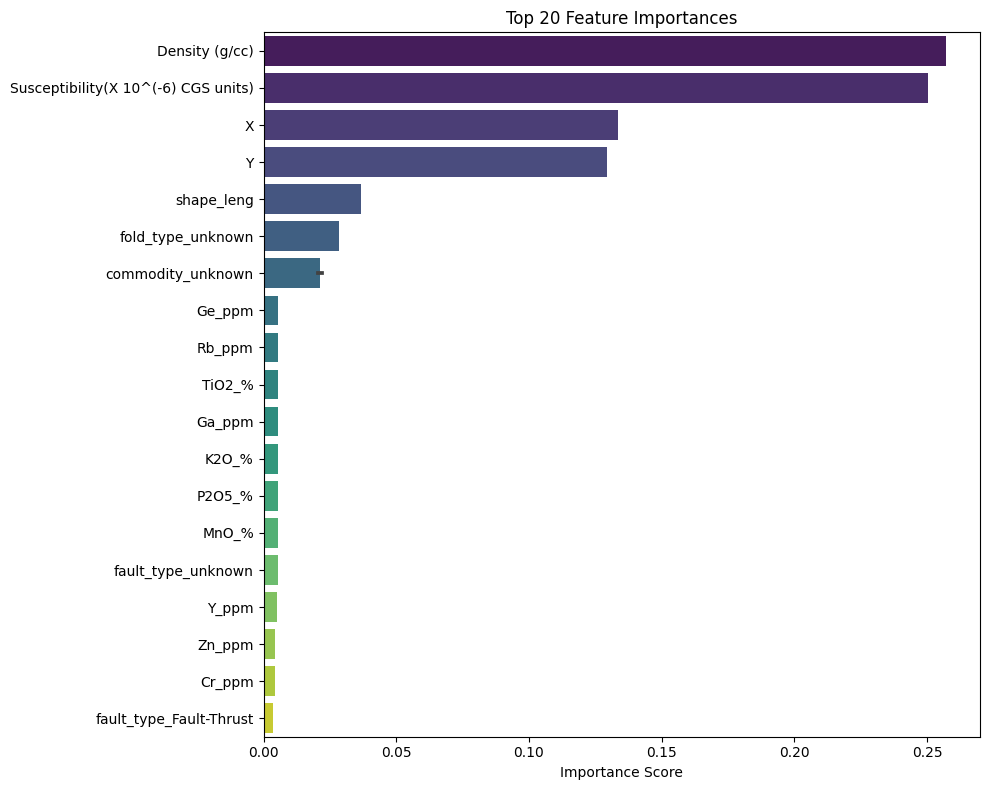

In [26]:

# Step 10: Feature Importance Plot
importances = model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feat_imp[:20], y=feat_imp.index[:20], palette='viridis')
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

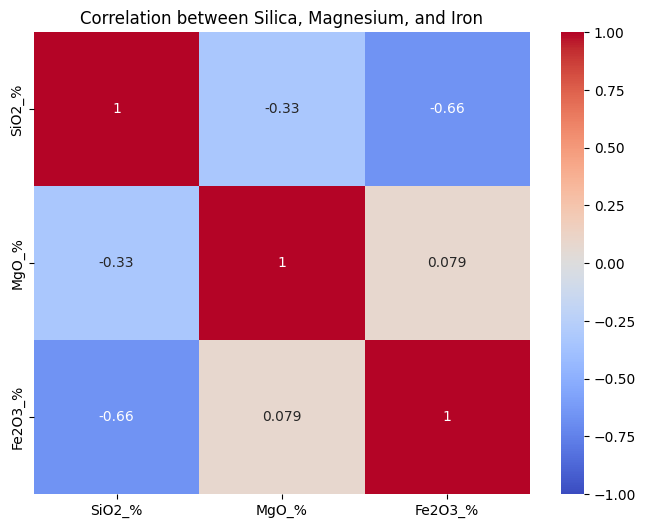

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data=pd.read_csv("./sedimentary/NGCM-Stream-Sediment-Analysis-Updated.csv")
# Sample data (replace with your geochemical data)
data1 = {
    'SiO2_%': data['Si02_%'].values,
    'MgO_%': data['MgO_%'].values,
    'Fe2O3_%':data['Fe2O3_%'].values 
}

# Create a DataFrame
df = pd.DataFrame(data1)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation between Silica, Magnesium, and Iron')
plt.show()


In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#data=pd.read_csv("./sedimentary/NGCM-Stream-Sediment-Analysis-Updated.csv")
data_proper=pd.read_csv("./classificationofminerals/Physical_properties_rock_samples.csv")


In [59]:

cat_cols = data_proper.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le  # save the encoder


data1 = {
    'Density': data_proper['Density (g/cc)'].values,
    
    'Rpck_type':data_proper['Rock_type'].values 
}

# Create a DataFrame
df = pd.DataFrame(data1)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation between Density and Rock Type')
plt.show()


ValueError: could not convert string to float: 'Pink Granite'

<Figure size 800x600 with 0 Axes>